# 0.0 IMPORTS

In [47]:
!pip install inflection
!pip install virtualenv
!pip install pipreqs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from google.colab import drive
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image


In [55]:
#Gerar arquivo requirements
%cd '/content/drive/MyDrive/Colab Notebooks/ds_em_producao'
!pip freeze > requirements.txt

/content/drive/MyDrive/Colab Notebooks/ds_em_producao


## 0.1. Virtual Environment

In [51]:
!virtualenv myenv

created virtual environment CPython3.9.16.final.0-64 in 17606ms
  creator CPython3Posix(dest=/content/drive/MyDrive/Colab Notebooks/ds_em_producao/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.1, setuptools==67.6.1, wheel==0.40.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [52]:
#Sempre que iniciar o projeto e quiser usar o ambiente virtual usar esse comando
#!source myenv/bin/activate

In [ ]:
#!pip install -r '/content/drive/MyDrive/Colab Notebooks/ds_em_producao/requirements.txt'

##0.2 Helper Functions

In [3]:
def cramer_v( x, y ):
  cm = pd.crosstab( x, y ).as_matrix()
  n = cm.sum()
  r, k = cm.shape
  chi2 = ss.chi2_contingency( cm )[0]
  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()


In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3 Loading Data

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/ds_em_producao/data/'

In [7]:
df_sales_raw = pd.read_csv(path + 'train.csv', low_memory=False)
df_store_raw = pd.read_csv(path + 'store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [8]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [9]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,df1.columns))
df1.columns = cols_new

## 1.2. Data Dimensions

In [11]:
df1.shape

(1017209, 18)

## 1.3. Data Types

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.4.2 Fillout NA

In [15]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [16]:
# competition_distance 
##coloca um valor extremamente alta se o competition distance for NaN
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if np.isnan(x) else x)

# competition_open_since_month
##Se o valor for NaN substitui o mês localizado na coluna date
filtro_mes = lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) else x['competition_open_since_month']
df1['competition_open_since_month'] = df1.apply(filtro_mes, axis=1) 
    
 # competition_open_since_year 
filtro_ano = lambda x: x['date'].year if np.isnan(x['competition_open_since_year']) else x['competition_open_since_year']
df1['competition_open_since_year'] = df1.apply(filtro_ano, axis=1)              
               
# promo2_since_week
filtro_promo_week = lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week']
df1['promo2_since_week'] = df1.apply(filtro_promo_week, axis=1)    

# promo2_since_year
filtro_promo_year = lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year']
df1['promo2_since_year'] = df1.apply(filtro_promo_year, axis=1)

# promo_interval 
df1['promo_interval'].fillna(0,inplace=True)

months = { 1: 'Jan',
           2: 'Feb',
           3: 'Mar',
           4: 'Apr',
           5: 'May',
           6: 'Jun',
           7: 'Jul',
           8: 'Aug',
           9: 'Sept',
           10: 'Oct',
           11: 'Nov',
           12: 'Dec',
         }
##cria um coluna month_map com o nome do mês baseado na coluna date
df1['month_map'] = df1['date'].apply(lambda x: x.month)
def numero_em_mes(mes):
  return months[mes]
df1['month_map'] = df1['month_map'].apply(numero_em_mes) 
##cria uma coluna is_promo: se o mês do month_map estiver dentro da coluna promo_interval, retorna 1, senão 0
filtro_promo_map = lambda x: 1 if x['month_map'] in x['promo_interval'].split(',') else 0
df1['is_promo'] = df1.apply(lambda x: (1 if x['month_map'] in x['promo_interval'].split(',') else 0) if x['promo_interval'] != 0 else 0, axis=1)

In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5. Change Types

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.6. Descriptive Statistical

In [20]:
num_attributes = df1.select_dtypes(include=['int','float'])
categorical_attributes = df1.select_dtypes(exclude=['int','float'])

### 1.6.1 Numerical Attributes

In [21]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = num_attributes.agg(['std','mean','min','max', lambda x: x.max()-x.min(),'skew','kurtosis']).T.reset_index()
d1.rename(columns={'index':'attributes','<lambda>':'range'})


,attributes,std,mean,min,max,range,skew,kurtosis
0,store,321.908651,558.429727,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,1.997391,3.998341,1.0,7.0,6.0,0.001593,-1.246873
2,sales,3849.926175,5773.818972,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,464.411734,633.145946,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.375539,0.830107,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.485759,0.381515,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.383056,0.178647,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,12547.652996,5935.442677,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,3.311087,6.786849,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,5.515593,2010.324840,1900.0,2015.0,115.0,-7.235657,124.071304


### 1.6.2 Categorical Attributes

In [22]:
categorical_attributes.apply(lambda x: x.nunique())

date              942
state_holiday       4
store_type          4
assortment          3
promo_interval      4
month_map          12
dtype: int64

<ipython-input-23-a214128d281e>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


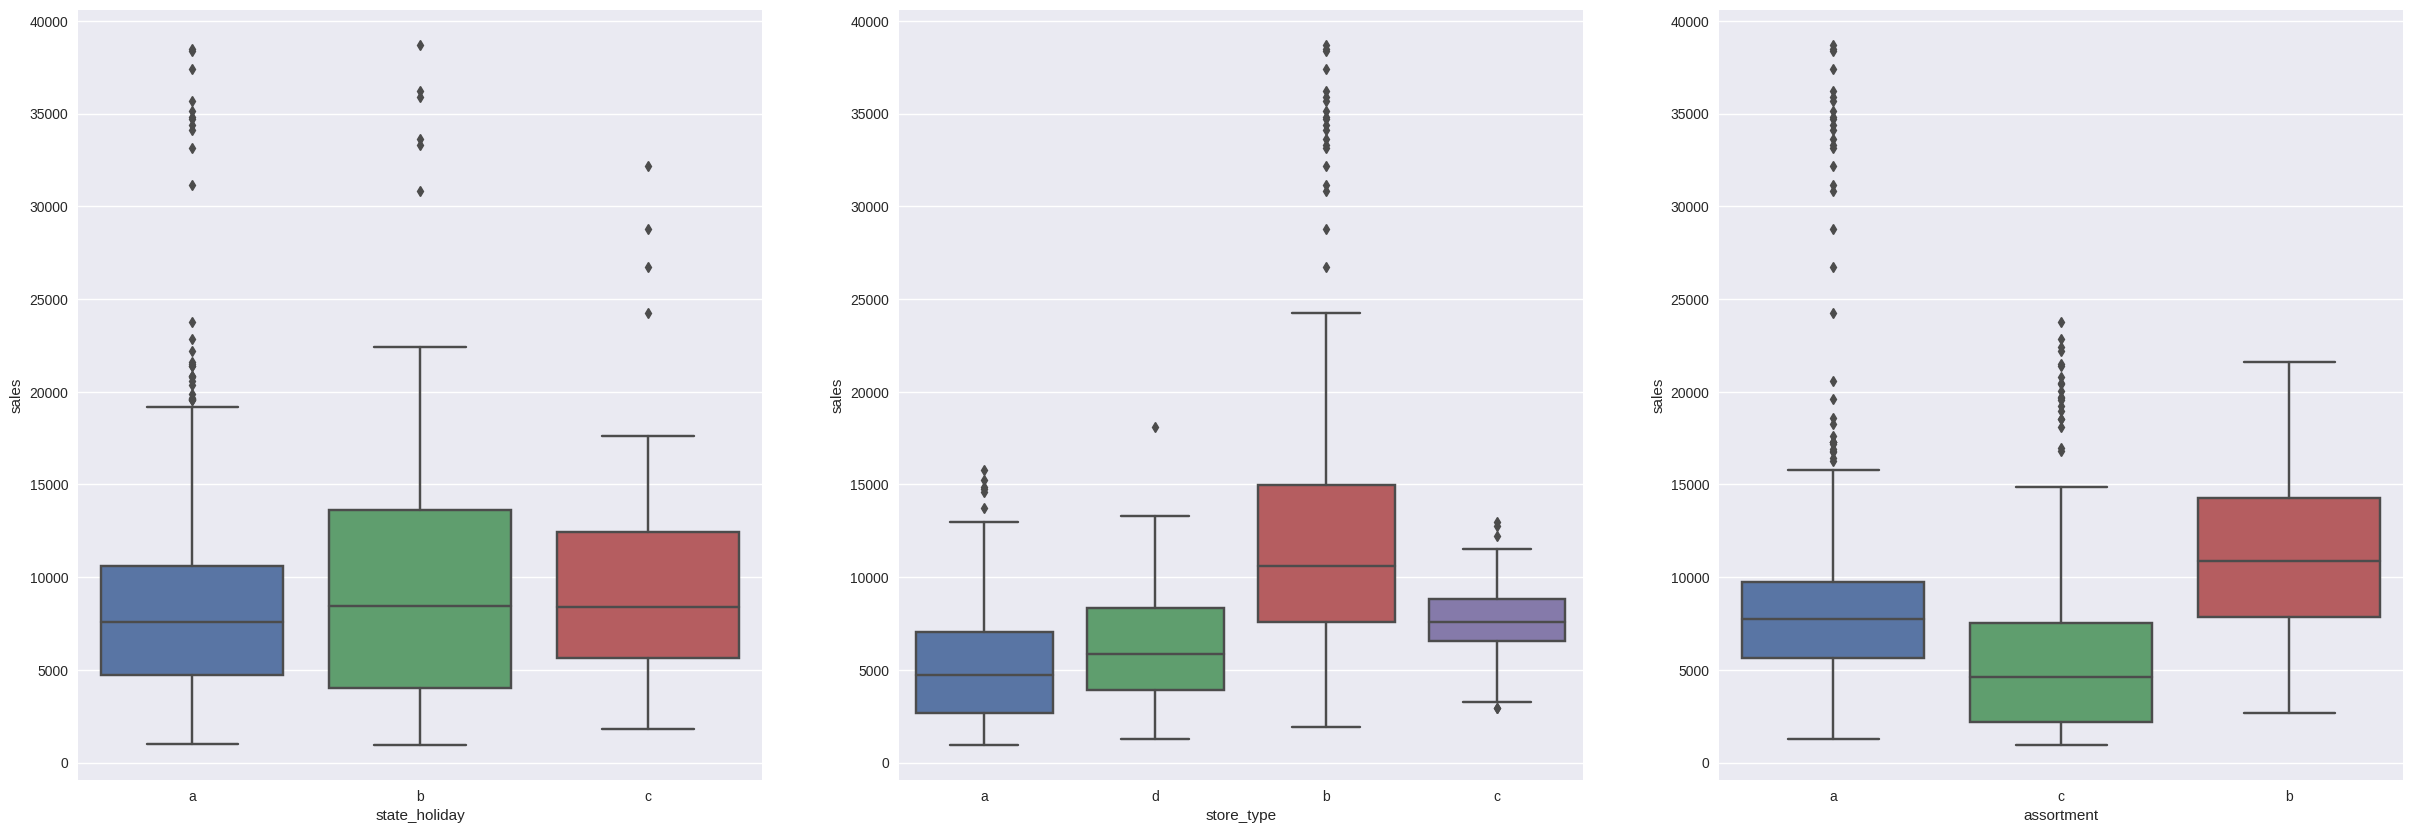

In [23]:
df1_aux = df1.loc[(df1['sales'] > 0) & (df1['state_holiday'] != '0'),:]

plt.style.use('seaborn')
fig = plt.figure(figsize=(30, 10))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=df1_aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=df1_aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=df1_aux)

plt.subplots_adjust(wspace=0.2)

fig.show()


# 2.0 FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## 2.1. Lista de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores a mais tempo deveriam vender mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana
12. Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Feature Engineering

In [25]:
df2.sample(10).T

,487229,173350,645690,473303,228199,862378,984360,980094,721488,716129
store,760,526,891,214,740,154,601,795,869,1085
day_of_week,1,4,6,6,4,7,3,7,1,6
date,2014-04-21 00:00:00,2015-02-26 00:00:00,2013-11-30 00:00:00,2014-05-03 00:00:00,2015-01-08 00:00:00,2013-05-19 00:00:00,2013-01-30 00:00:00,2013-02-03 00:00:00,2013-09-23 00:00:00,2013-09-28 00:00:00
sales,0,10030,12900,10810,7249,0,3611,0,10151,5140
customers,0,1426,1611,880,507,0,309,0,1242,542
open,0,1,1,1,1,0,1,0,1,1
promo,0,0,0,0,1,0,0,0,1,0
state_holiday,b,0,0,0,0,0,0,0,0,0
school_holiday,1,0,0,0,1,0,0,0,0,0
store_type,a,a,a,d,d,d,d,d,c,c


In [26]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
##Junta as duas colunas em uma só
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)

#promo since
#Junta as duas colunas em uma só transformando a semana em mês
df2['promo_since'] = df2.apply(lambda x: datetime.datetime.strptime(f"{x['promo2_since_year']}-{x['promo2_since_week']-1}-1", '%Y-%W-%w'),axis=1)

#assortment
assortments = {'a' : 'basic', 'b' : 'extra', 'c' : 'extended'}
def name_assortsments(valor):
  return assortments[valor]

df2['assortment'] = df2['assortment'].apply(name_assortsments)

#state holiday 
holidays = {'a' : 'public_holiday', 'b' : 'easter_holiday', 'c' : 'christmas', '0' : 'regular_day'}
def name_holidays(valor):
  return holidays[valor]

df2['state_holiday'] = df2['state_holiday'].apply(name_holidays)

#promo_time_week signifca quantos dias apos o pedido a promo2 está ativa(estendida)
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

<ipython-input-26-c96dae4329de>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 VARIABLE FILTERING

In [27]:
df3 = df2.copy()

In [28]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,2015-07-27,0


## 3.1.Line Filtering

In [29]:
#retirar coluna 'open' porque quando a loja está fechada não tem vendas
#filtrar coluna sales > 0 porque não quero sales negativa
df3 = df3.loc[(df3['sales']>0) & (df3['open'] != 0 ) ]

## 3.2. Columns Selection

In [30]:
#dropar coluna costumers porque não vou ter quantos customer estarão na loja daqui a 6 semanas
#dropar open porque só vai sobrar '1' na coluna
#os outros drops são colunas derivadas
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

#4.0 EXPLORATORY DATA ANALISYS

In [31]:
df4 = df3.copy()

In [32]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,2015-07-27,0


In [33]:
df4.sample(10).T

,25429,493977,163411,713439,989533,346775,280524,505273,773286,906047
store,900,818,622,625,199,78,245,964,262,338
day_of_week,4,2,6,1,5,4,5,6,3,3
date,2015-07-09 00:00:00,2014-04-15 00:00:00,2015-03-07 00:00:00,2013-09-30 00:00:00,2013-01-25 00:00:00,2014-09-04 00:00:00,2014-11-14 00:00:00,2014-04-05 00:00:00,2013-08-07 00:00:00,2013-04-10 00:00:00
sales,5737,8825,2976,5503,7702,3770,9249,10504,16481,9604
promo,0,1,0,0,1,1,1,0,0,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,1,0,0,0,0,0,0,0,0
store_type,a,d,a,a,d,a,a,a,b,a
assortment,basic,basic,extended,basic,extended,basic,extended,basic,basic,extended
competition_distance,3920.0,490.0,200000.0,1170.0,6360.0,3510.0,1310.0,270.0,1180.0,1590.0


##4.1 Unilateral Analysis

###4.1.1 Response Variable

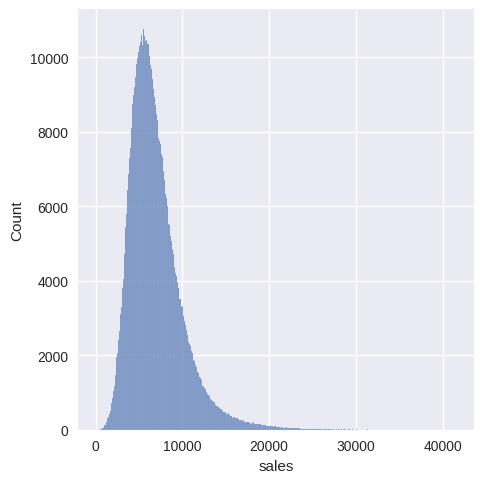

In [54]:
sns.displot(df4['sales']);

###4.1.2 Numerical Variables

<ipython-input-35-860b5680d9e5>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(ax = ax, bins=25);


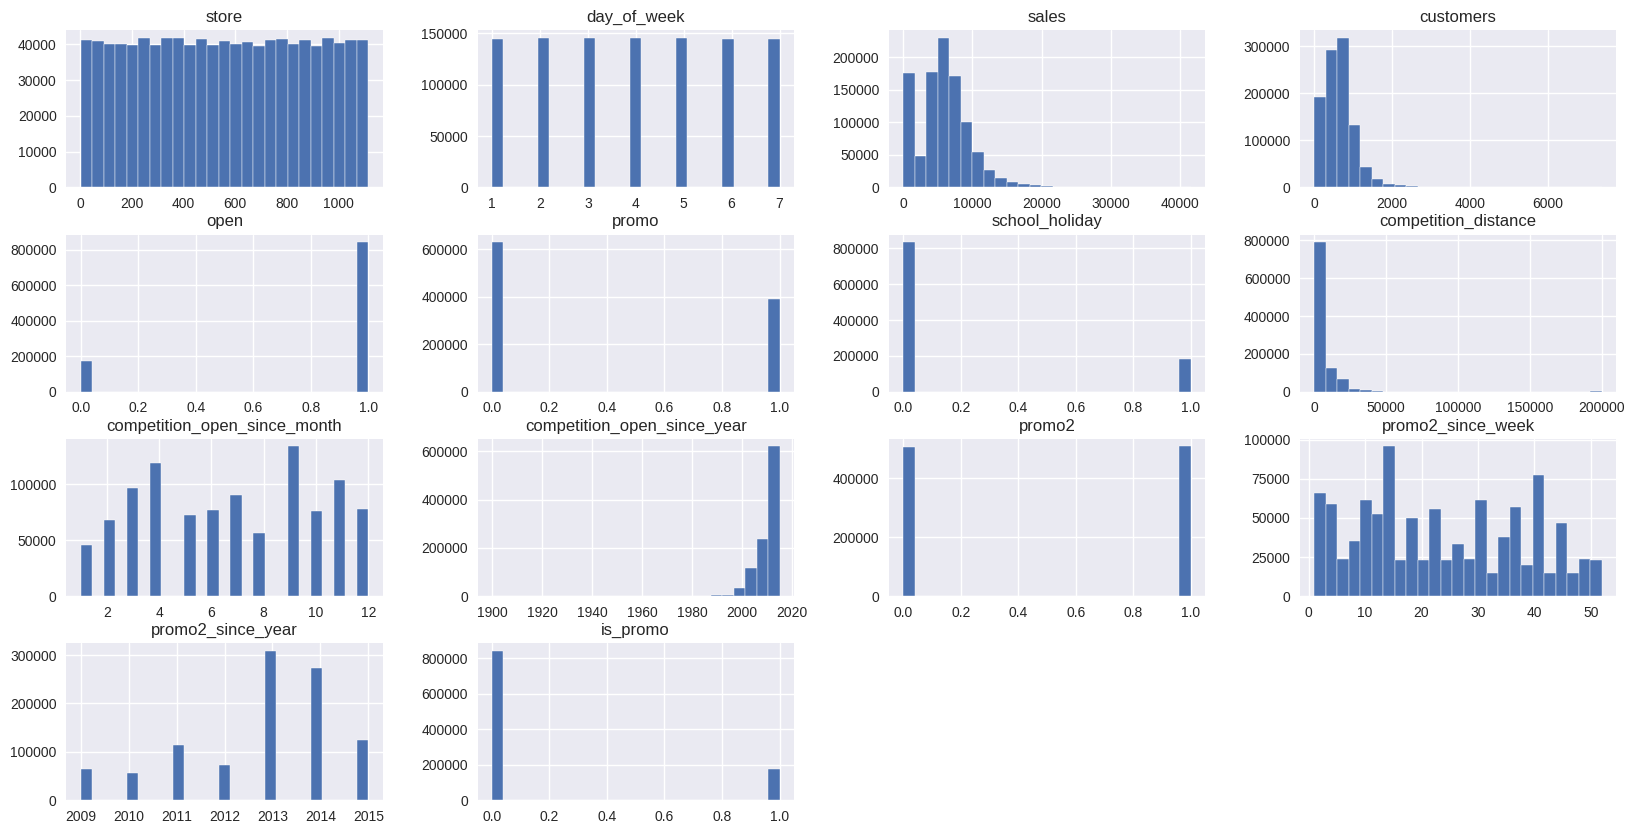

In [35]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
num_attributes.hist(ax = ax, bins=25);

###4.1.3 Categorical Variable

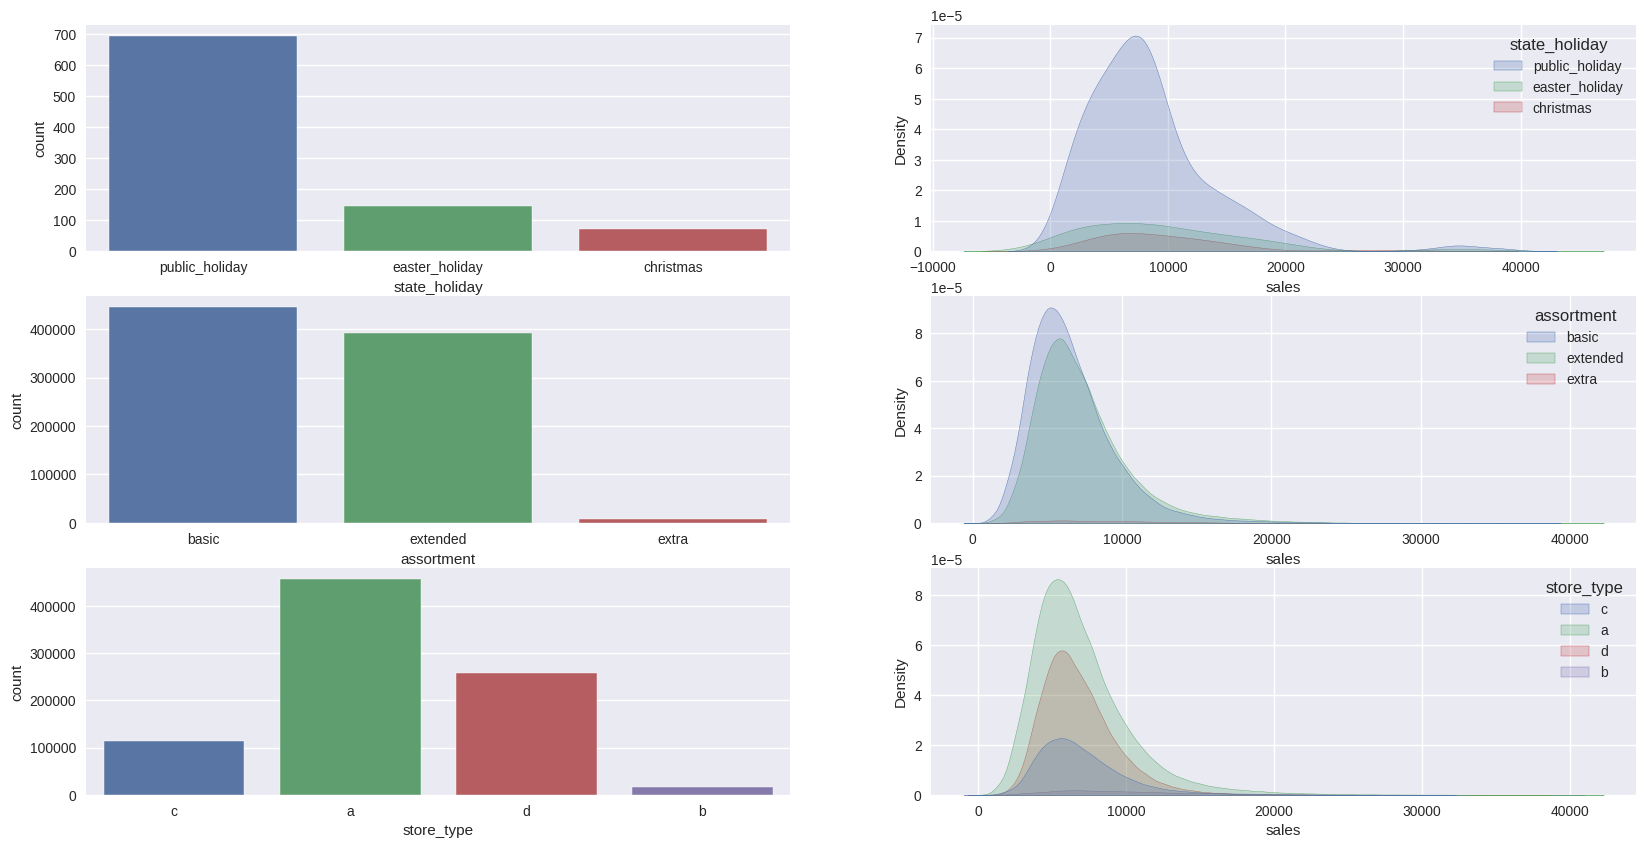

In [36]:
not_regular_day = df4.loc[df4['state_holiday'] != 'regular_day',['sales','state_holiday']]

#state_holiday
fig = plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
sns.countplot(data = not_regular_day, x='state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(data=not_regular_day, x='sales', hue='state_holiday', fill=True)

#assortment
plt.subplot(3,2,3)
sns.countplot(data = df4, x='assortment')

plt.subplot(3,2,4)
sns.kdeplot(data=df4, x='sales', hue='assortment', fill=True)

#store_type
plt.subplot(3,2,5)
sns.countplot(data = df4, x='store_type')

plt.subplot(3,2,6)
sns.kdeplot(data=df4, x='sales', hue='store_type', fill=True)

fig.show()

##4.2 Bilateral Analysis

###4.2.1 - H1 - Lojas com maior sortimentos deveriam vender mais.
**Supondo que o sortimento extra seja o maior, a hipótese é falsa,
porque a extra possui a menor quantidade de venda dos 3 sortimentos**

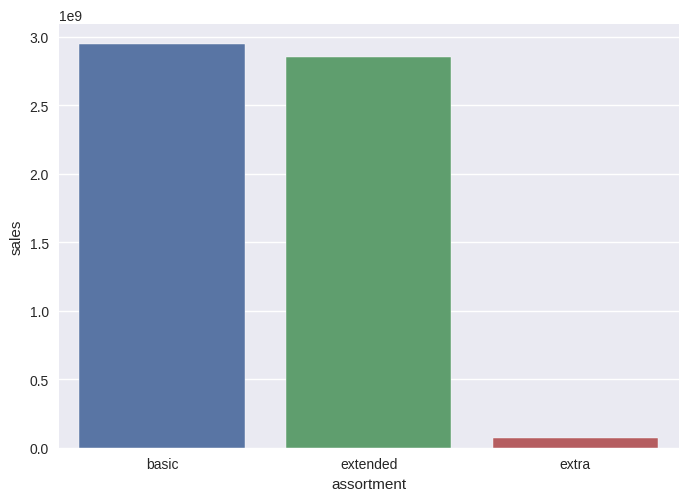

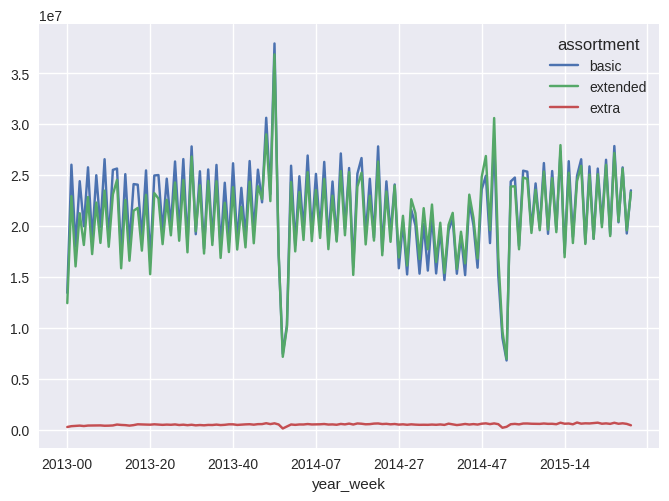

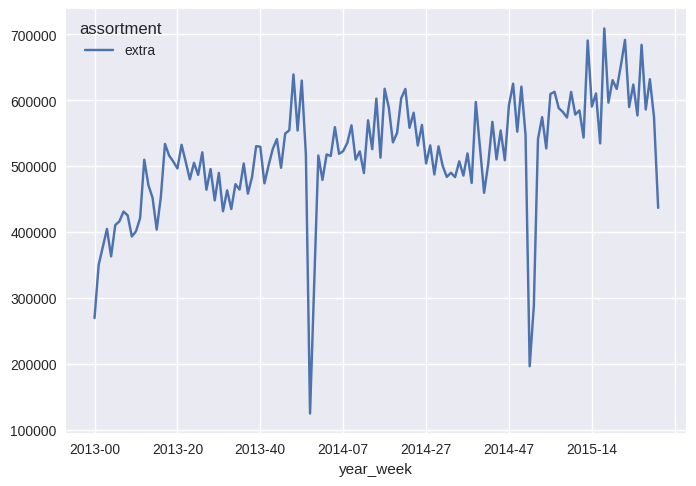

In [37]:

sales_assortment = df4[['sales','assortment']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=sales_assortment)

sales_assortment_time = df4[['sales','assortment','year_week']].groupby(['assortment','year_week']).sum().reset_index()
sales_assortment_time.pivot(index='year_week',columns='assortment',values='sales').plot()

sales_assortment_time_extra = df4.loc[df4['assortment'] == 'extra',['year_week','sales','assortment']].groupby(['assortment','year_week']).sum().reset_index()
sales_assortment_time_extra.pivot(index='year_week',columns='assortment',values='sales').plot()

fig.show()

###4.2.2 - H2 - Loja com competidores mais próximos deveriam vender menos.
**Falso. Lojas com competidores mais próximos vende MAIS.**


<ipython-input-38-b8c14d8f5f62>:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df4_competition_distance.corr(method='pearson'),annot=True)


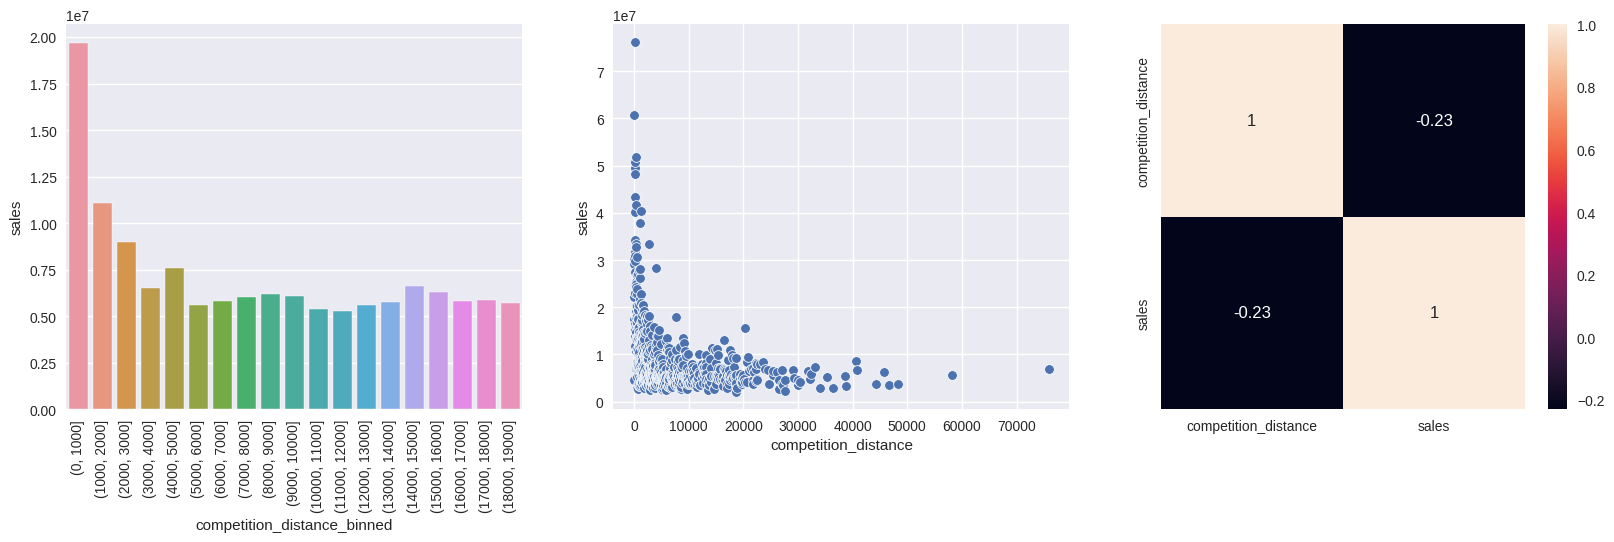

In [38]:
df4_competition_distance = df4.loc[:,['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000,1000))
df4_competition_distance['competition_distance_binned'] = pd.cut(df4_competition_distance['competition_distance'], bins=bins)

fig = plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.barplot(x='competition_distance_binned',y='sales',data=df4_competition_distance, errorbar=None)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
mask = df4_competition_distance.loc[df4_competition_distance['competition_distance'] < 100000,:]
sns.scatterplot(x='competition_distance',y='sales',data=mask )

plt.subplot(1,3,3)
sns.heatmap(df4_competition_distance.corr(method='pearson'),annot=True)



fig.show()

###4.2.3 - H3 - Lojas com competidores a mais tempo deveriam vender mais.
**Falso. Lojas com competidores mais recentes vende MAIS.**

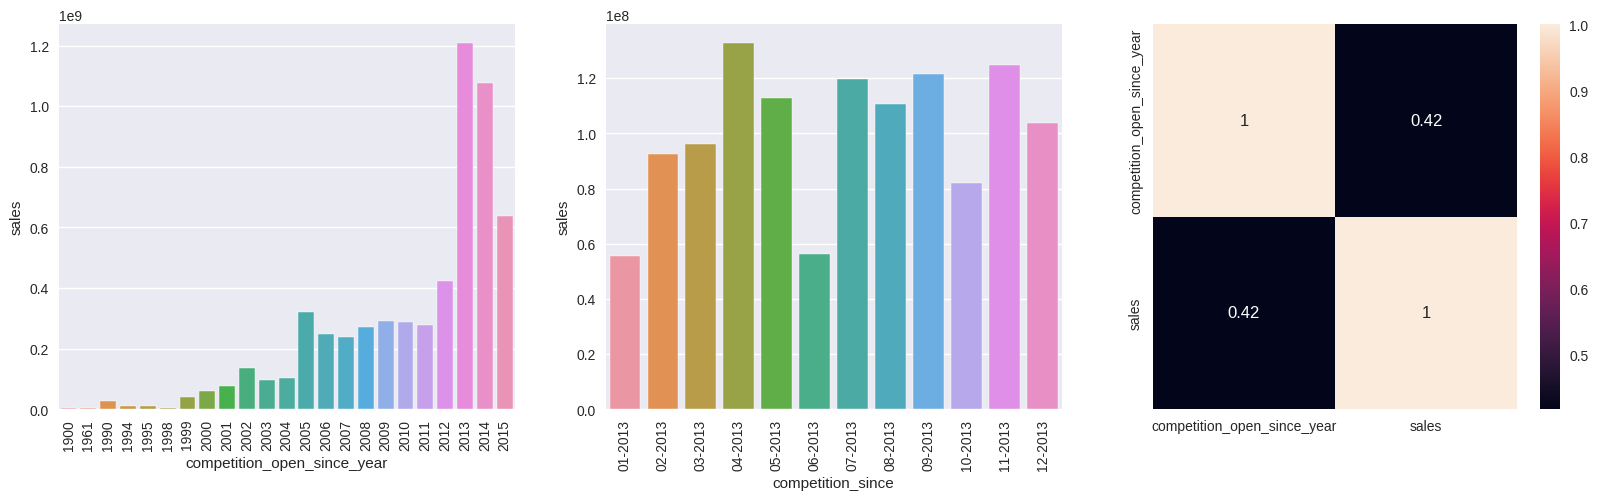

In [39]:
fig = plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
df4_competition_time = df4.loc[:,['competition_open_since_year','sales']].groupby('competition_open_since_year').sum().reset_index()
sns.barplot(x='competition_open_since_year',y='sales',data=df4_competition_time)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
df4_competition_time_2013 = df4.loc[df4['competition_since'].dt.year == 2013,['competition_since','sales']].groupby('competition_since').sum().reset_index()
df4_competition_time_2013['competition_since'] = df4_competition_time_2013['competition_since'].dt.strftime('%m-%Y')
sns.barplot(x='competition_since',y='sales',data=df4_competition_time_2013)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(df4_competition_time.corr(method='pearson'),annot=True)

fig.show()

### 4.2.4 Lojas com Promoções ativas por mais tempo deveiriam vender mais. Falso. As vendas se mantém relativamente constantes após a promoção.


In [40]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,2015-07-27,0


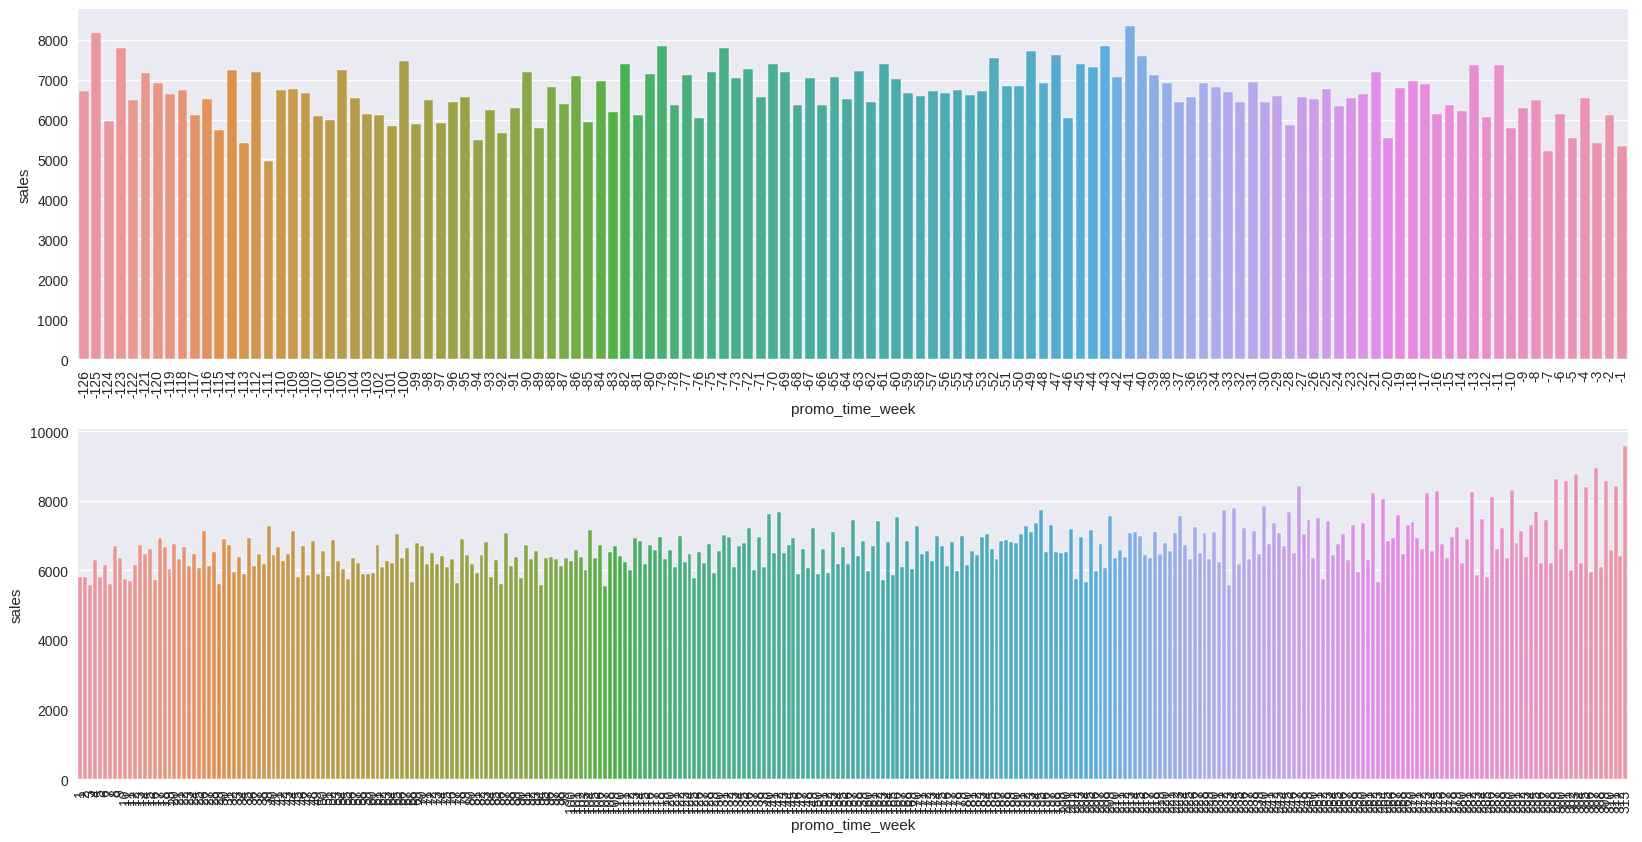

In [41]:
df4_promo_since_regular = df4.loc[df4['promo_time_week'] < 0,:] #regular promo
df4_promo_since_promo2 = df4.loc[df4['promo_time_week']> 0,:]

fig = plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
sns.barplot(x='promo_time_week',y='sales',data=df4_promo_since_regular, errorbar=None)
plt.xticks(rotation=90)

plt.subplot(2,1,2)
sns.barplot(x='promo_time_week',y='sales',data=df4_promo_since_promo2, errorbar=None)
plt.xticks(rotation=90)

fig.show()

###4.2.5 Lojas com mais promoções consecutivas deveriam vender mais. Falso. Lojas com promocões consecutivas vendem Menos.

In [42]:
df4.loc[:,['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


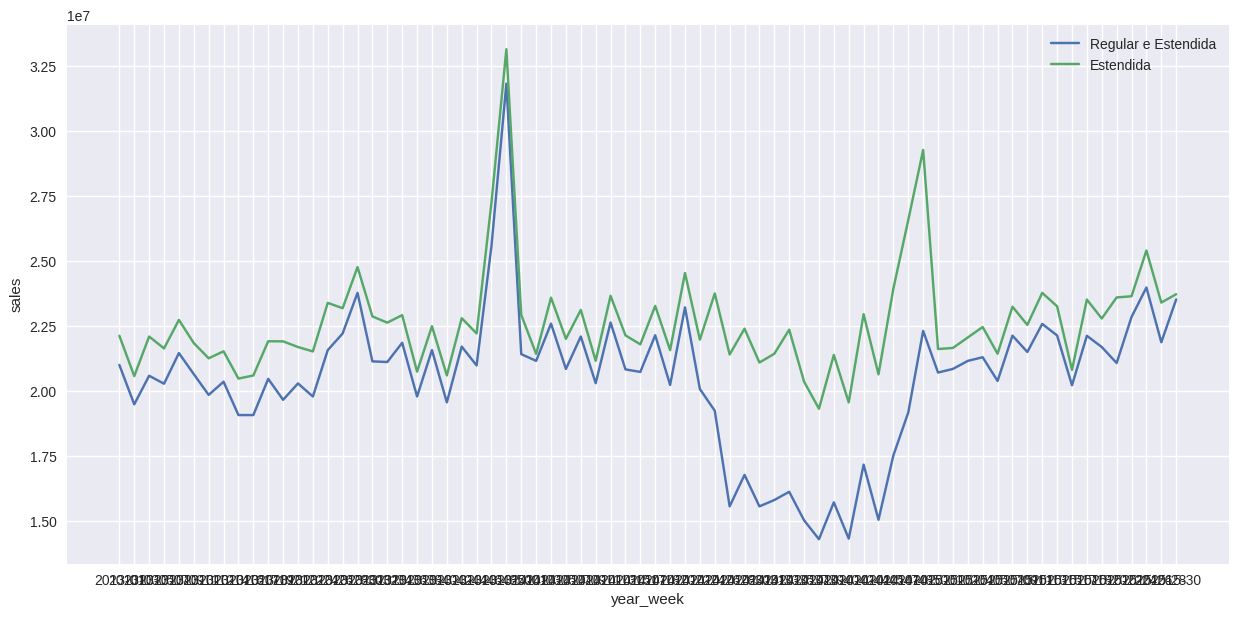

In [43]:
df4_regular_extendida = df4.loc[(df4['promo'] == 1) & (df4['promo2'] == 1),['sales','year_week']].groupby('year_week').sum().reset_index()
df4_apenas_extendida = df4.loc[(df4['promo'] == 1) & (df4['promo2'] == 0),['sales','year_week']].groupby('year_week').sum().reset_index()

plt.figure(figsize=(15,7))

sns.lineplot(x='year_week',y='sales',data=df4_regular_extendida, label='Regular e Estendida')

sns.lineplot(x='year_week',y='sales',data=df4_apenas_extendida, label='Estendida')

fig.show()

##4.3 Multilateral Analysis

###H8. Lojas aberturas durante o Natal Deveriam vender mais. Falso. O Natal é o feriado que menos vende.

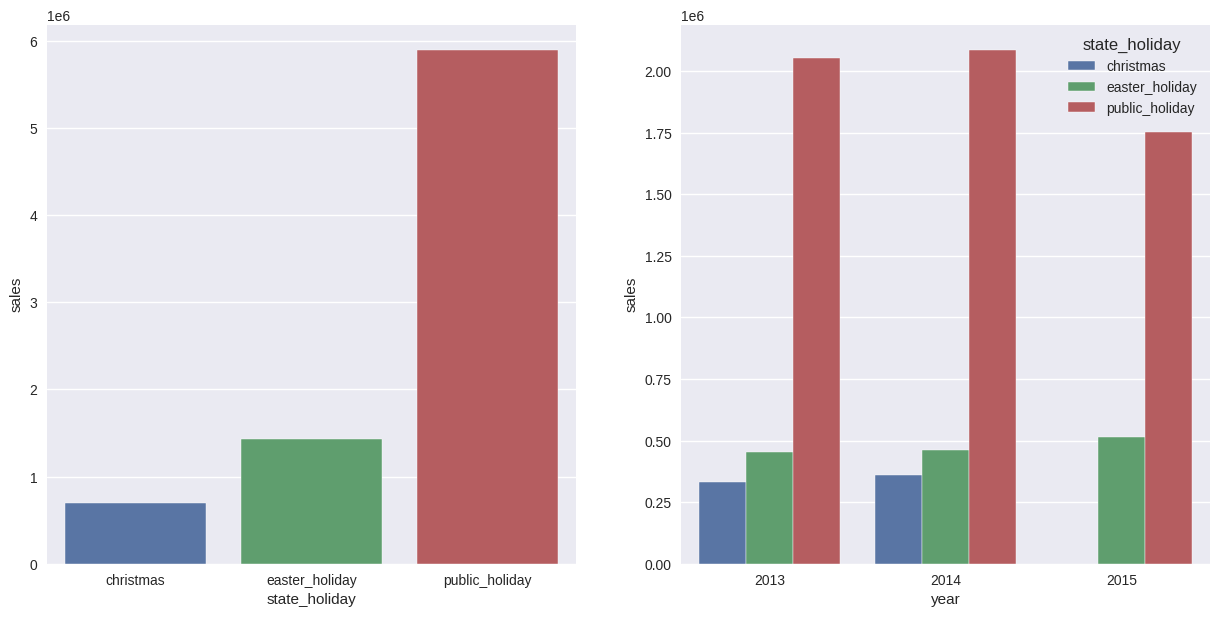

In [66]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
df4_christmas = df4.loc[df4['state_holiday'] != 'regular_day',['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=df4_christmas)

plt.subplot(1,2,2)
df4_christmas = df4.loc[df4['state_holiday'] != 'regular_day',['state_holiday','sales','year']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=df4_christmas, errorbar=None)

fig.show()

###H9. Lojas deveriam vender mais ao longo dos anos. Falso. As vendas caem ao longo dos anos

<Axes: >

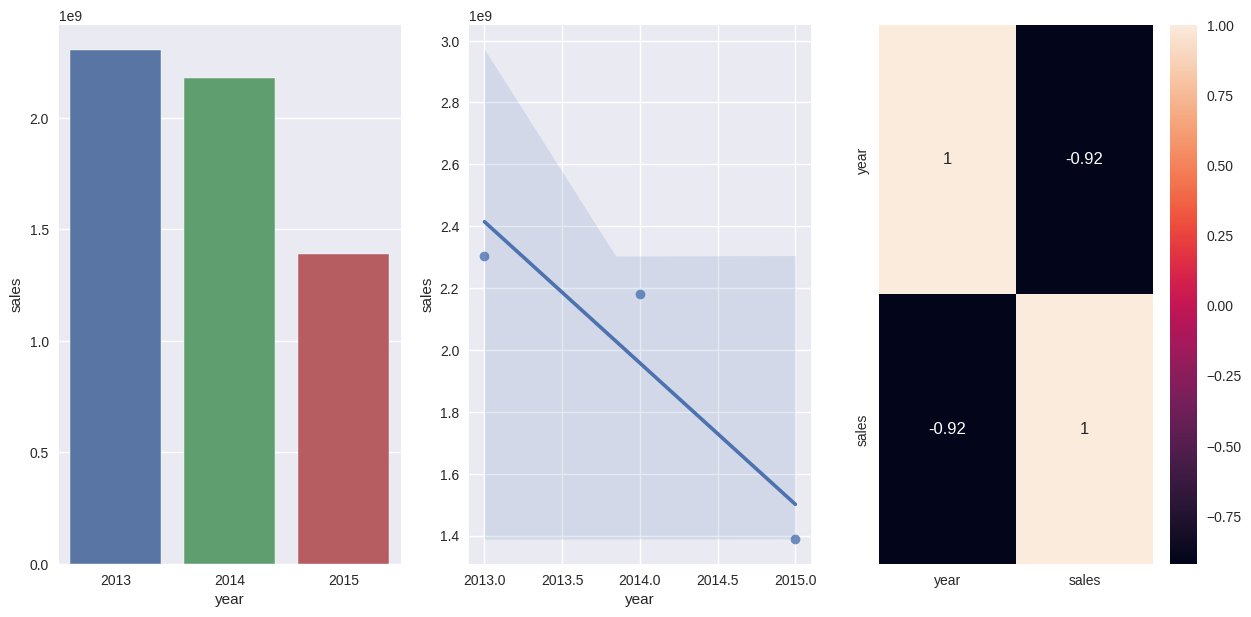

In [69]:
df4_vendas_anos = df4.loc[:,['sales','year']].groupby('year').sum().reset_index()

plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=df4_vendas_anos)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=df4_vendas_anos)

plt.subplot(1,3,3)
sns.heatmap(df4_vendas_anos.corr(method='pearson'), annot=True)

###H10. Lojas deveriam vender mais no segundo semestre. As lojas vendem menos no segundo semestre do ano

<Axes: >

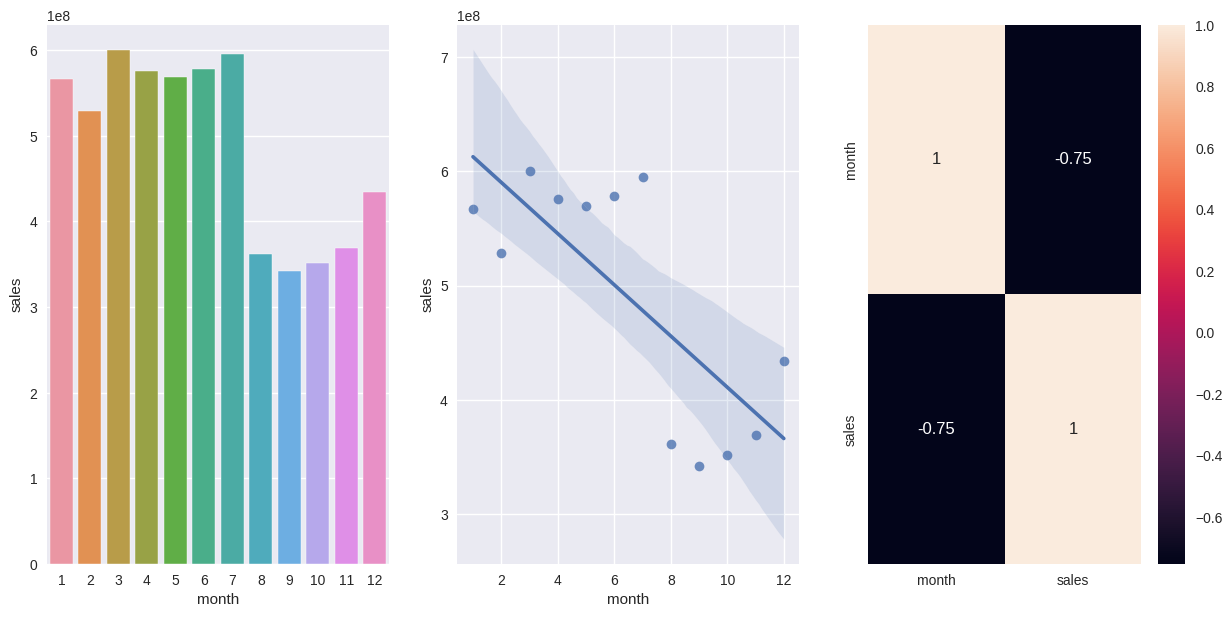

In [70]:
df4_vendas_meses = df4.loc[:,['sales','month']].groupby('month').sum().reset_index()

plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=df4_vendas_meses)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=df4_vendas_meses)

plt.subplot(1,3,3)
sns.heatmap(df4_vendas_meses.corr(method='pearson'), annot=True)

###H11. Lojas deveriam vender mais depois do dia 10 de cada mês. Verdade. As lojas tem uma quantidade de vendas maiores após o dia 10.

<Axes: xlabel='before_after', ylabel='sales'>

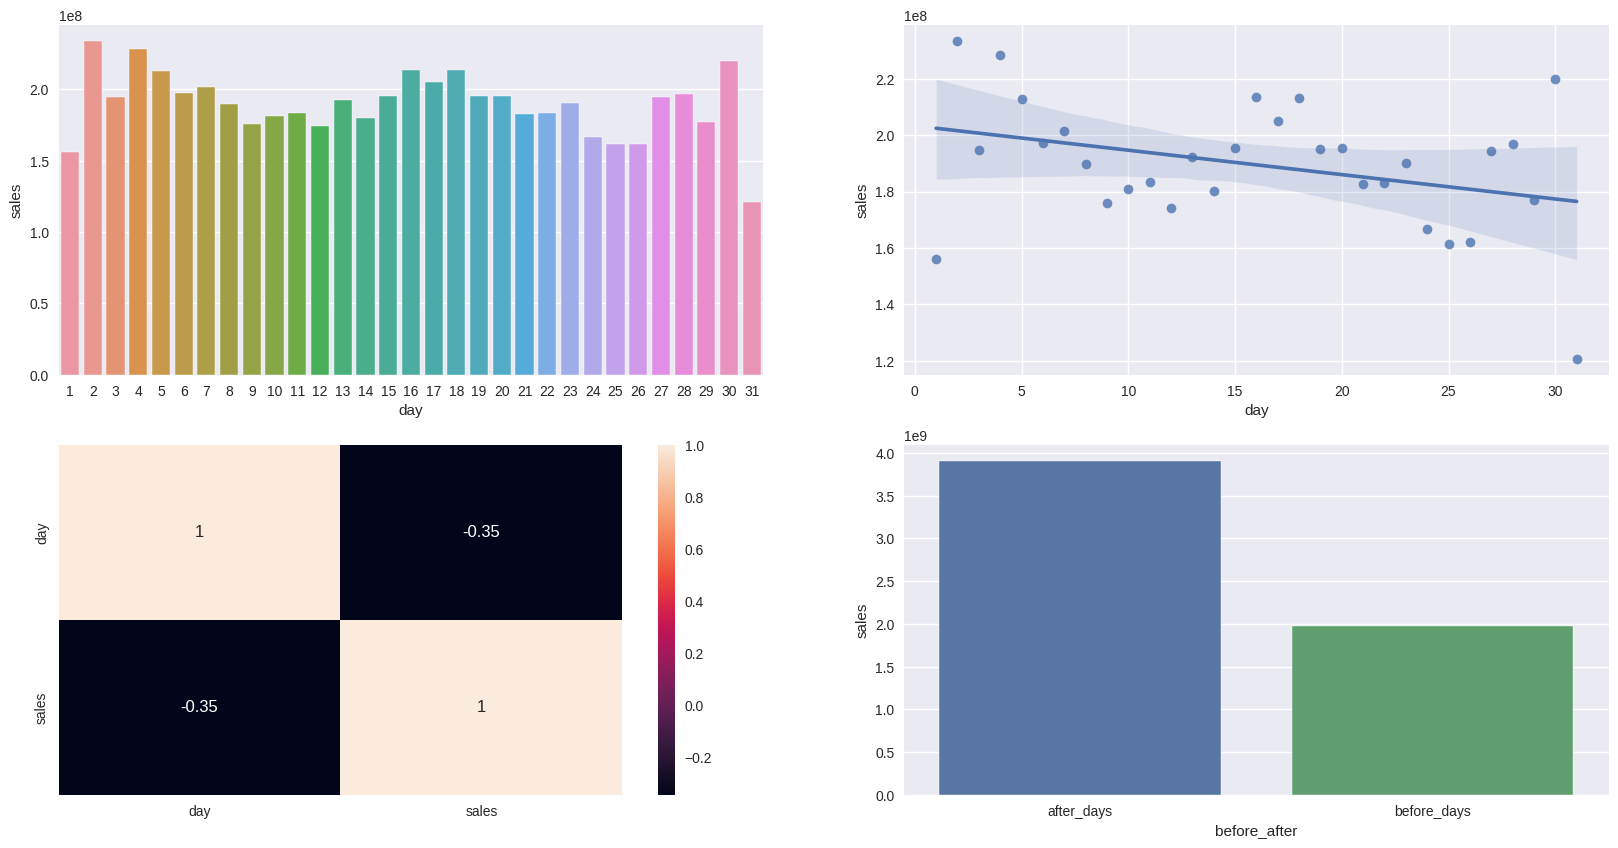

In [86]:
df4_vendas_dias = df4.loc[:,['sales','day']].groupby('day').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=df4_vendas_dias)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=df4_vendas_dias)

plt.subplot(2,2,3)
sns.heatmap(df4_vendas_dias.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)
df4_vendas_dias['before_after'] = df4_vendas_dias['day'].apply(lambda x: 'after_days' if x > 10 else 'before_days')
df4_before_after = df4_vendas_dias.loc[:,['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=df4_before_after, errorbar=None)

###H12. Lojas deveriam vender menos aos finais de semana. VERDADE. Lojas vendem bem menos durante os fins de semana.

<Axes: xlabel='weekend', ylabel='sales'>

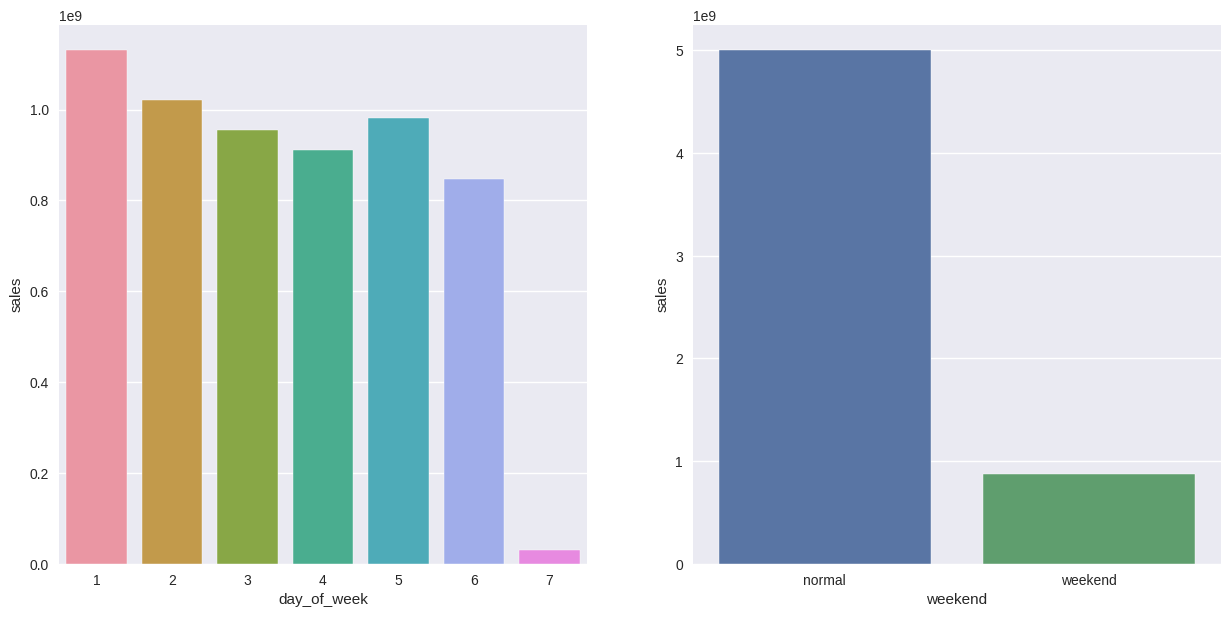

In [94]:
df4_vendas_fds = df4.loc[:,['sales','day_of_week']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.barplot(x='day_of_week', y='sales', data=df4_vendas_fds)


df4_vendas_fds['weekend'] = df4_vendas_fds['day_of_week'].apply(lambda x: 'weekend' if x >=6 else 'normal')
df4_weekend = df4_vendas_fds.loc[:,['weekend','sales']].groupby('weekend').sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x='weekend', y='sales', data=df4_weekend)

###H13. Vendas deveriam ser menor nos feriados escolares. VERDADE. Detalhe para o mês 7 que quase se igualam.

<Axes: xlabel='month', ylabel='sales'>

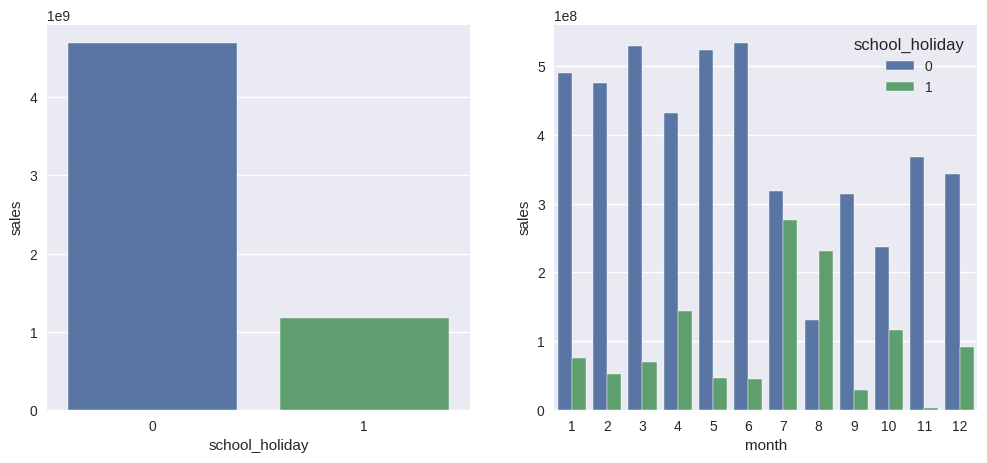

In [104]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
df4_school_holiday = df4.loc[:,['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=df4_school_holiday)

plt.subplot(1,2,2)
df4_school_holiday_month = df4.loc[:,['school_holiday','sales','month']].groupby(['school_holiday','month']).sum().reset_index()
sns.barplot(x='month', y='sales', data=df4_school_holiday_month, hue='school_holiday')